# Predict seasonal CO2 concentration

Time Series prediction is a useful tool for many areas of physics and society.
Here we will use keras to predict the seasonal CO2 concentration change from our previous homework.
Note: here we looking into the seasonal change whereas in the previous homework we were looking into the seasonal corrected outlook.

Loosly based on [https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

Start with importing libraries

In [269]:
%pylab inline
import pandas as pd
import tensorflow as tf
from tensorflow import keras

Populating the interactive namespace from numpy and matplotlib


/home/tim/.pyenv/versions/3.8.8/envs/compphys_tf2.4/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


This code is written for 
- tensorflow/keras 2.4. 
- Pandas version 1.2.3. 
- Python version 3.8.8. 

So check your versions first:

In [270]:
import sys
print("Python: {}".format(sys.version))
print("tensorflow: {}".format(tf.__version__))
print("keras: {}".format(keras.__version__))
print("pandas: {}".format(pd.__version__))

Python: 3.8.8 (default, Mar 19 2021, 10:05:53) 
[GCC 9.3.0]
tensorflow: 2.4.0
keras: 2.4.0
pandas: 1.2.3


## Data input
Let's read in out CO2 data in frist.
We skip the header rows and are only interested in the non-season corrected monthly average and set the decimal date as our index:

In [3]:
dfraw = pd.read_fwf('../DataAnalysis/FFT/co2_mm_mlo.txt',skiprows=71,index_col=2)

Let's filter out all missing values

In [4]:
df = dfraw.iloc[:,2][dfraw.iloc[:,2]>0]

<AxesSubplot:xlabel='date'>

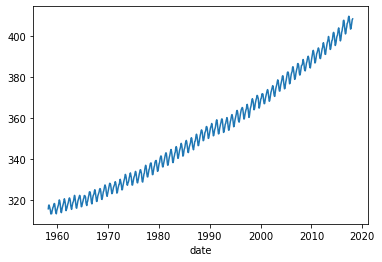

In [5]:
df.plot()

In [329]:
x2= np.arange(0,100)
y2 = np.tan(x2/100)
df = pd.DataFrame(y2,index=x2)

For our model it is convenient to use normalized data, so we take the mean and divide by the standard derivation:

In [330]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

<AxesSubplot:>

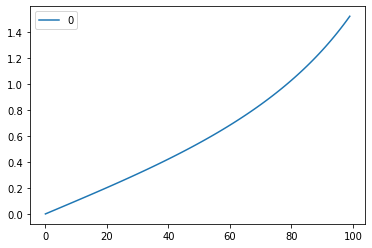

In [331]:
df.plot()

## Create Dataset

In the next step we split our dataset into a training set and a validation (test) set.
This helps us to validate the training against a known future.
You can experiment with the split ratio.

In [332]:
splitRatio = 0.67
train_size = int(len(df) * splitRatio)
test_size = len(df) - train_size
train =(df).iloc[0:train_size].values # normalize
test = (df).iloc[train_size:].values
print("length of training set: {},\nlength of validation set: {}".format(len(train), len(test)))

length of training set: 67,
length of validation set: 33


Now we create a dataset for our model.
There are also built in functions

`keras.preprocessing.timeseries_dataset_from_array`

[https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array]

for that but for educational purposes we do that ourselves.

In [333]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)][0]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

What did we do here?
We use a *look_back* variable to define the amount of months we want to use to predict the future.
Then we stack up an $n+1$ dimensional array that uses the original timeseries shifted by *look_back*.
This gives us the data for our model.

Let's have a look at it:

In [334]:
x,y = create_dataset(df.iloc[0:10].values)
dd = pd.DataFrame(y.squeeze(),index=x.squeeze())
dd

,0
0.000000,0.010000
0.010000,0.020003
0.020003,0.030009
0.030009,0.040021
0.040021,0.050042
0.050042,0.060072
0.060072,0.070115
0.070115,0.080171


In [335]:
len(dd.values)

8

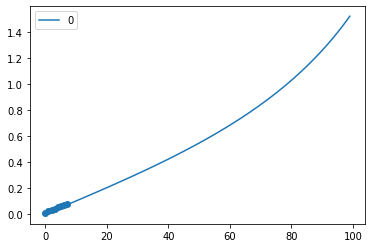

In [336]:
df.plot()
scatter(df.index[:8],dd.values)

Depending on *look_back* we shifted the timeseries in the following row.

Let's do it for our dataset:

In [337]:
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

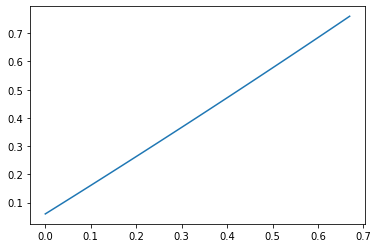

In [338]:
plot(trainX,trainY)

## Create Model
now we create our model.
What changes if you use less or more hidden layers?
You can also play around with the loss function and the optimizer to see the effects.
We use a batch size of zero for our dataset.

In [345]:
with tf.device("cpu:0"):
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, input_dim=1, activation='relu'))
    #model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=1500, batch_size=0, verbose=0)
    model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 64)                128       
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


## Estimate model performance

In [346]:
with tf.device("cpu:0"):
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print("Train Score: {:.2f} MSE".format(trainScore))
    testScore = model.evaluate(testX, testY, verbose=0)
    print("Test Score: {:.2f} MSE".format(testScore))

Train Score: 0.00 MSE
Test Score: 0.01 MSE


## Prediction

Now use the keras predition to validate our data.
Is that the expected outcome?

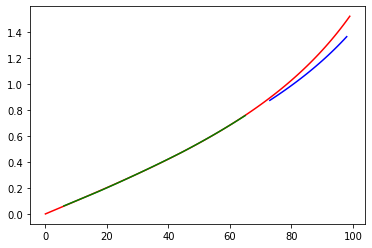

In [347]:
with tf.device("cpu:0"):
    # generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # shift train predictions for plotting
    #trainPredictPlot = np.empty_like(df.iloc[0:train_size].values)
    #trainPredictPlot[:,:] = np.nan
    #trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]
    # shift test predictions for plotting
    #testPredictPlot = np.empty_like(df)
    #testPredictPlot[:] = np.nan
    #testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1] = testPredict[:,0]
    # plot baseline and predictions
    plt.plot((df).values,"-r")
    plt.plot(np.arange(look_back,len(trainPredict)+look_back),trainPredict,"-g")
    plt.plot(np.arange(len(trainPredict)+(look_back*2)+1,len(df)-1),testPredict,"-b")
    #ylim(-2,2)
    plt.show()
    